California House Price Prediction

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request


def load_housing_data():
    datasets_dir = Path("datasets")
    datasets_dir.mkdir(exist_ok=True)
    tarball_path = datasets_dir / "housing.tgz"
    if not tarball_path.is_file():
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path=datasets_dir)
    return pd.read_csv(datasets_dir/"housing/housing.csv")

housing = load_housing_data()

In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [4]:
housing.head(50)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
housing[(housing["population"] >= 450) & (housing["median_income"] >= 5)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
104,-121.77,37.33,9.0,3160.0,468.0,1675.0,470.0,7.5443,348400.0,<1H OCEAN
105,-118.50,33.97,29.0,2737.0,808.0,1157.0,696.0,5.1280,500001.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
20532,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,229200.0,<1H OCEAN
20533,-118.40,33.92,25.0,1453.0,271.0,695.0,283.0,5.9499,345800.0,<1H OCEAN
20539,-117.95,33.86,35.0,2478.0,431.0,1333.0,427.0,5.2099,191400.0,<1H OCEAN
20567,-121.79,38.66,15.0,6809.0,1052.0,3060.0,1060.0,5.3064,165000.0,INLAND


Ploting Histogram of the Data

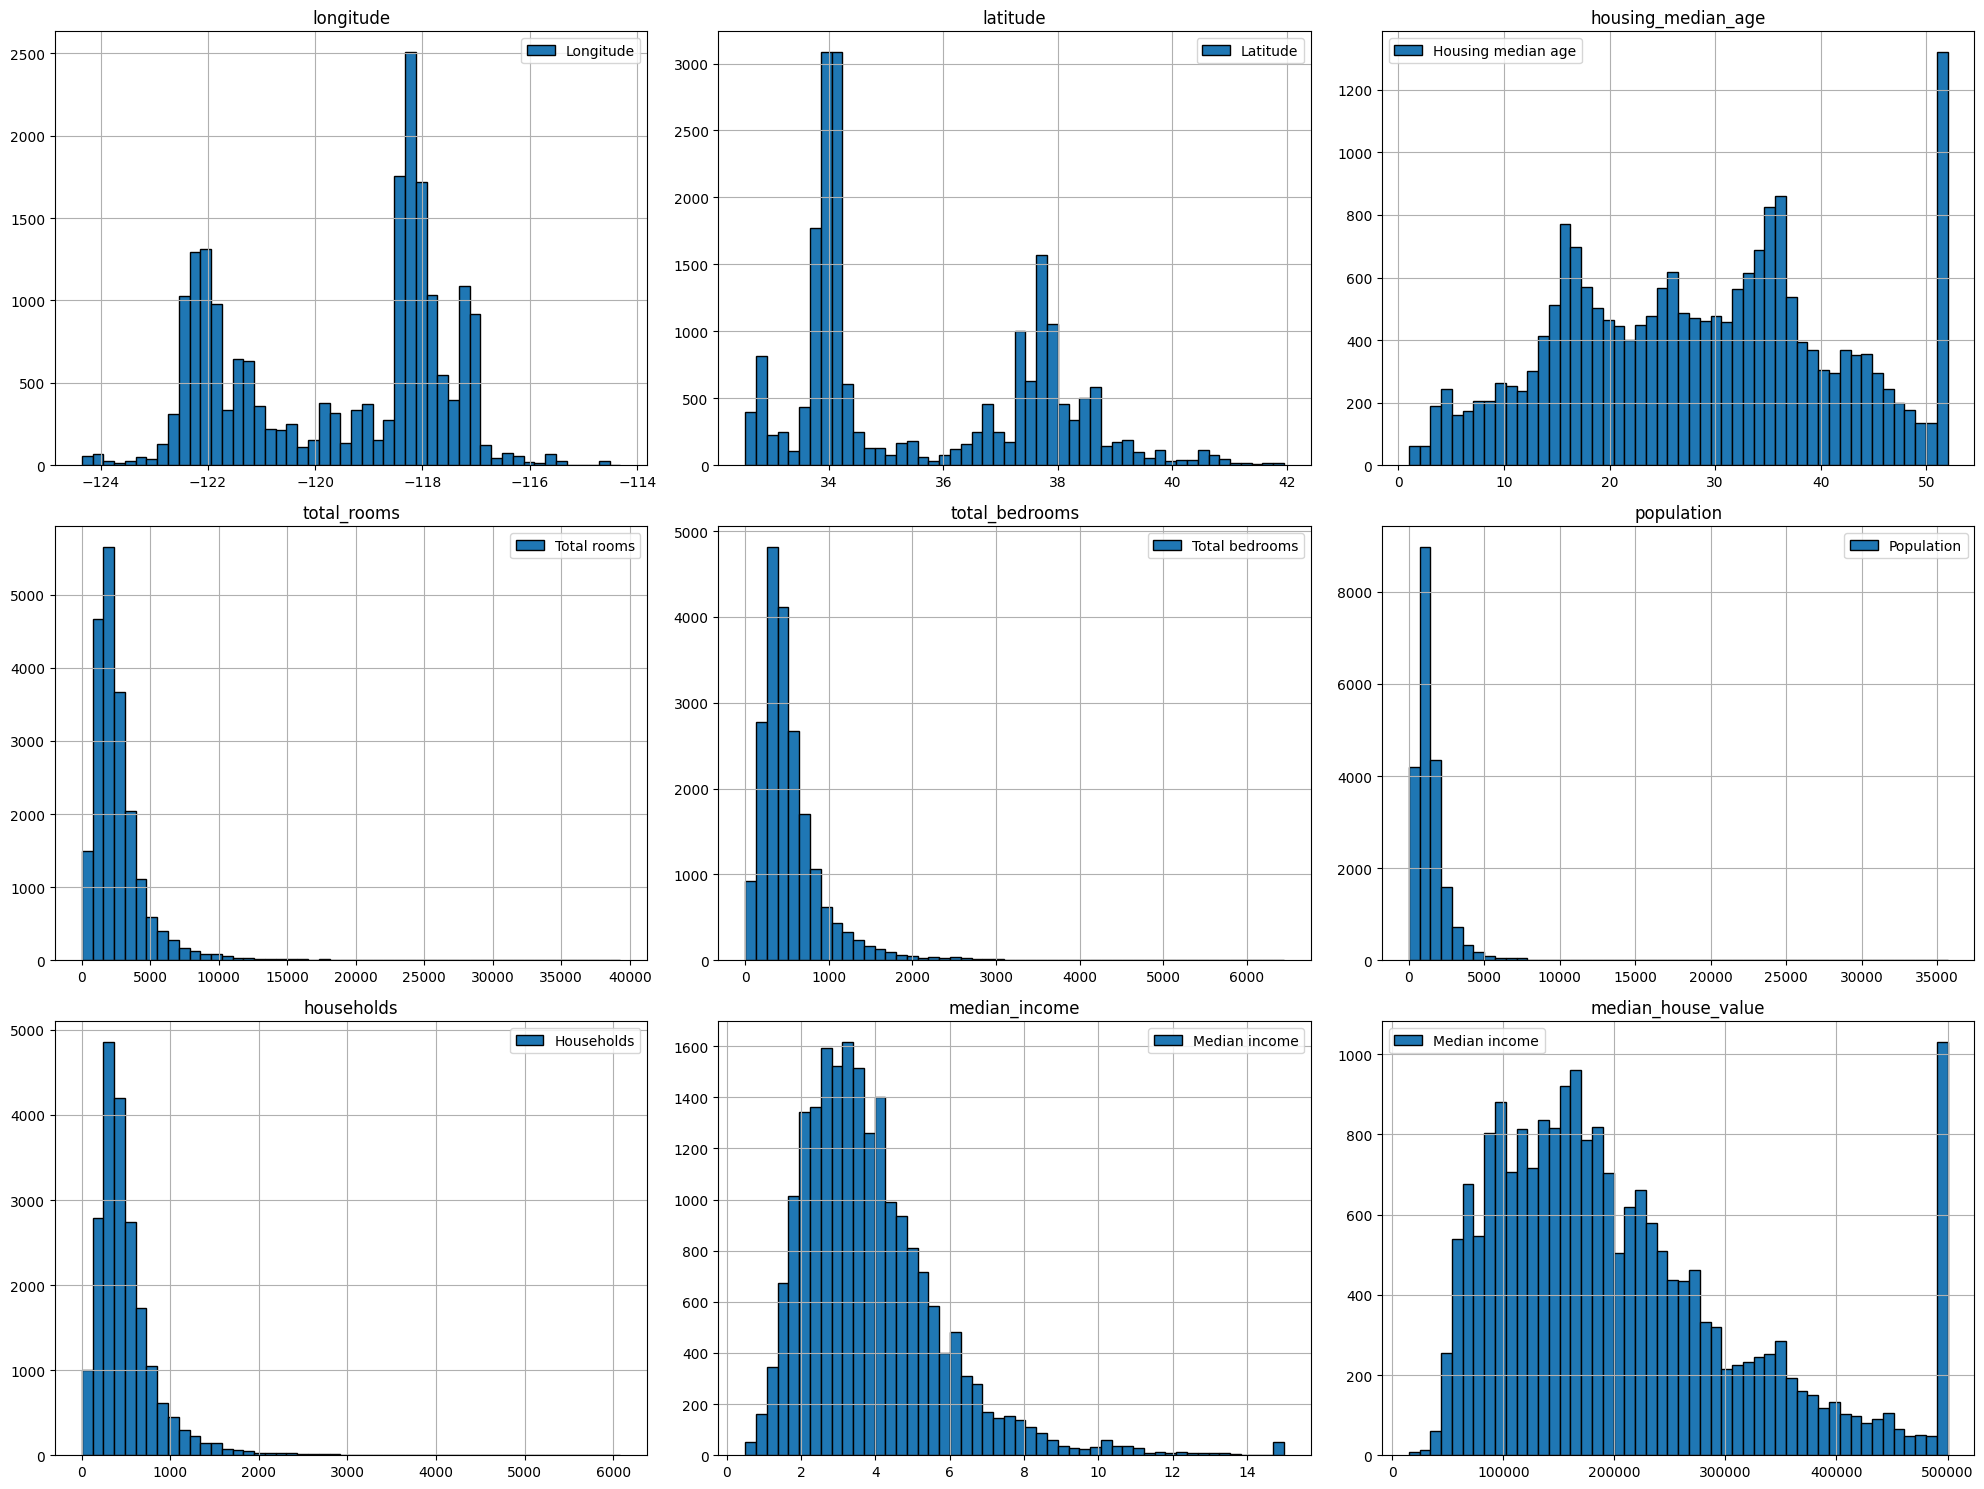

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(20, 15), tight_layout=True)

ax[0, 0].hist(housing["longitude"], bins=50, edgecolor="black", label="Longitude")
ax[0, 1].hist(housing["latitude"], bins=50, edgecolor="black", label="Latitude")
ax[0, 2].hist(housing["housing_median_age"], bins=50, edgecolor="black", label="Housing median age", )

ax[1, 0].hist(housing["total_rooms"], bins=50, edgecolor="black", label="Total rooms")
ax[1, 1].hist(housing["total_bedrooms"], bins=50, edgecolor="black", label="Total bedrooms")
ax[1, 2].hist(housing["population"], bins=50, edgecolor="black", label="Population")

ax[2, 0].hist(housing["households"], bins=50, edgecolor="black", label="Households")
ax[2, 1].hist(housing["median_income"], bins=50, edgecolor="black", label="Median income")
ax[2, 2].hist(housing["median_house_value"], bins=50, edgecolor="black", label="Median income")

for i in range(3):
    for j in range(3):
        ax[i, j].legend()
        ax[i, j].set_title(housing.columns[i * 3 + j])
        ax[i, j].grid(True)
plt.show()


# OR just run the code below

# housing.hist(bins=50, edgecolor="black")
# plt.show()

Creating a Test Set

In [8]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2)
    

In [9]:
len(train_set), len(test_set)

(16512, 4128)

In [10]:
from zlib import crc32


def is_id_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32


def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [12]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Using Sklearn for Spliting the data for training and testing

In [13]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [14]:
test_set["total_bedrooms"].isnull().sum()

np.int64(44)

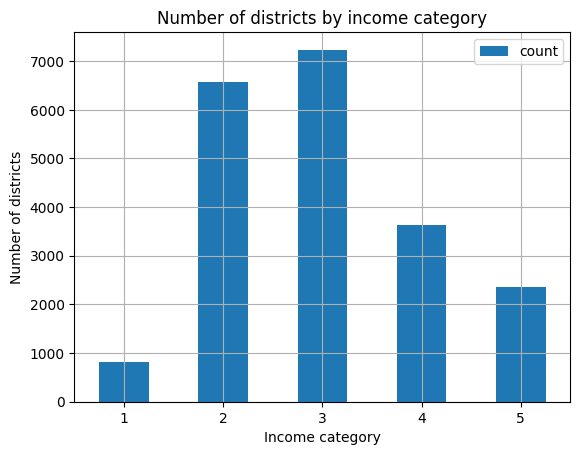

In [15]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.title("Number of districts by income category")
plt.legend()
plt.show()

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    strat_splits.append([strat_train_set, strat_test_set])
    
strat_train_set, strat_test_set = strat_splits[0]


In [17]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

In [18]:
housing = strat_train_set.copy()

Visualizing the Data

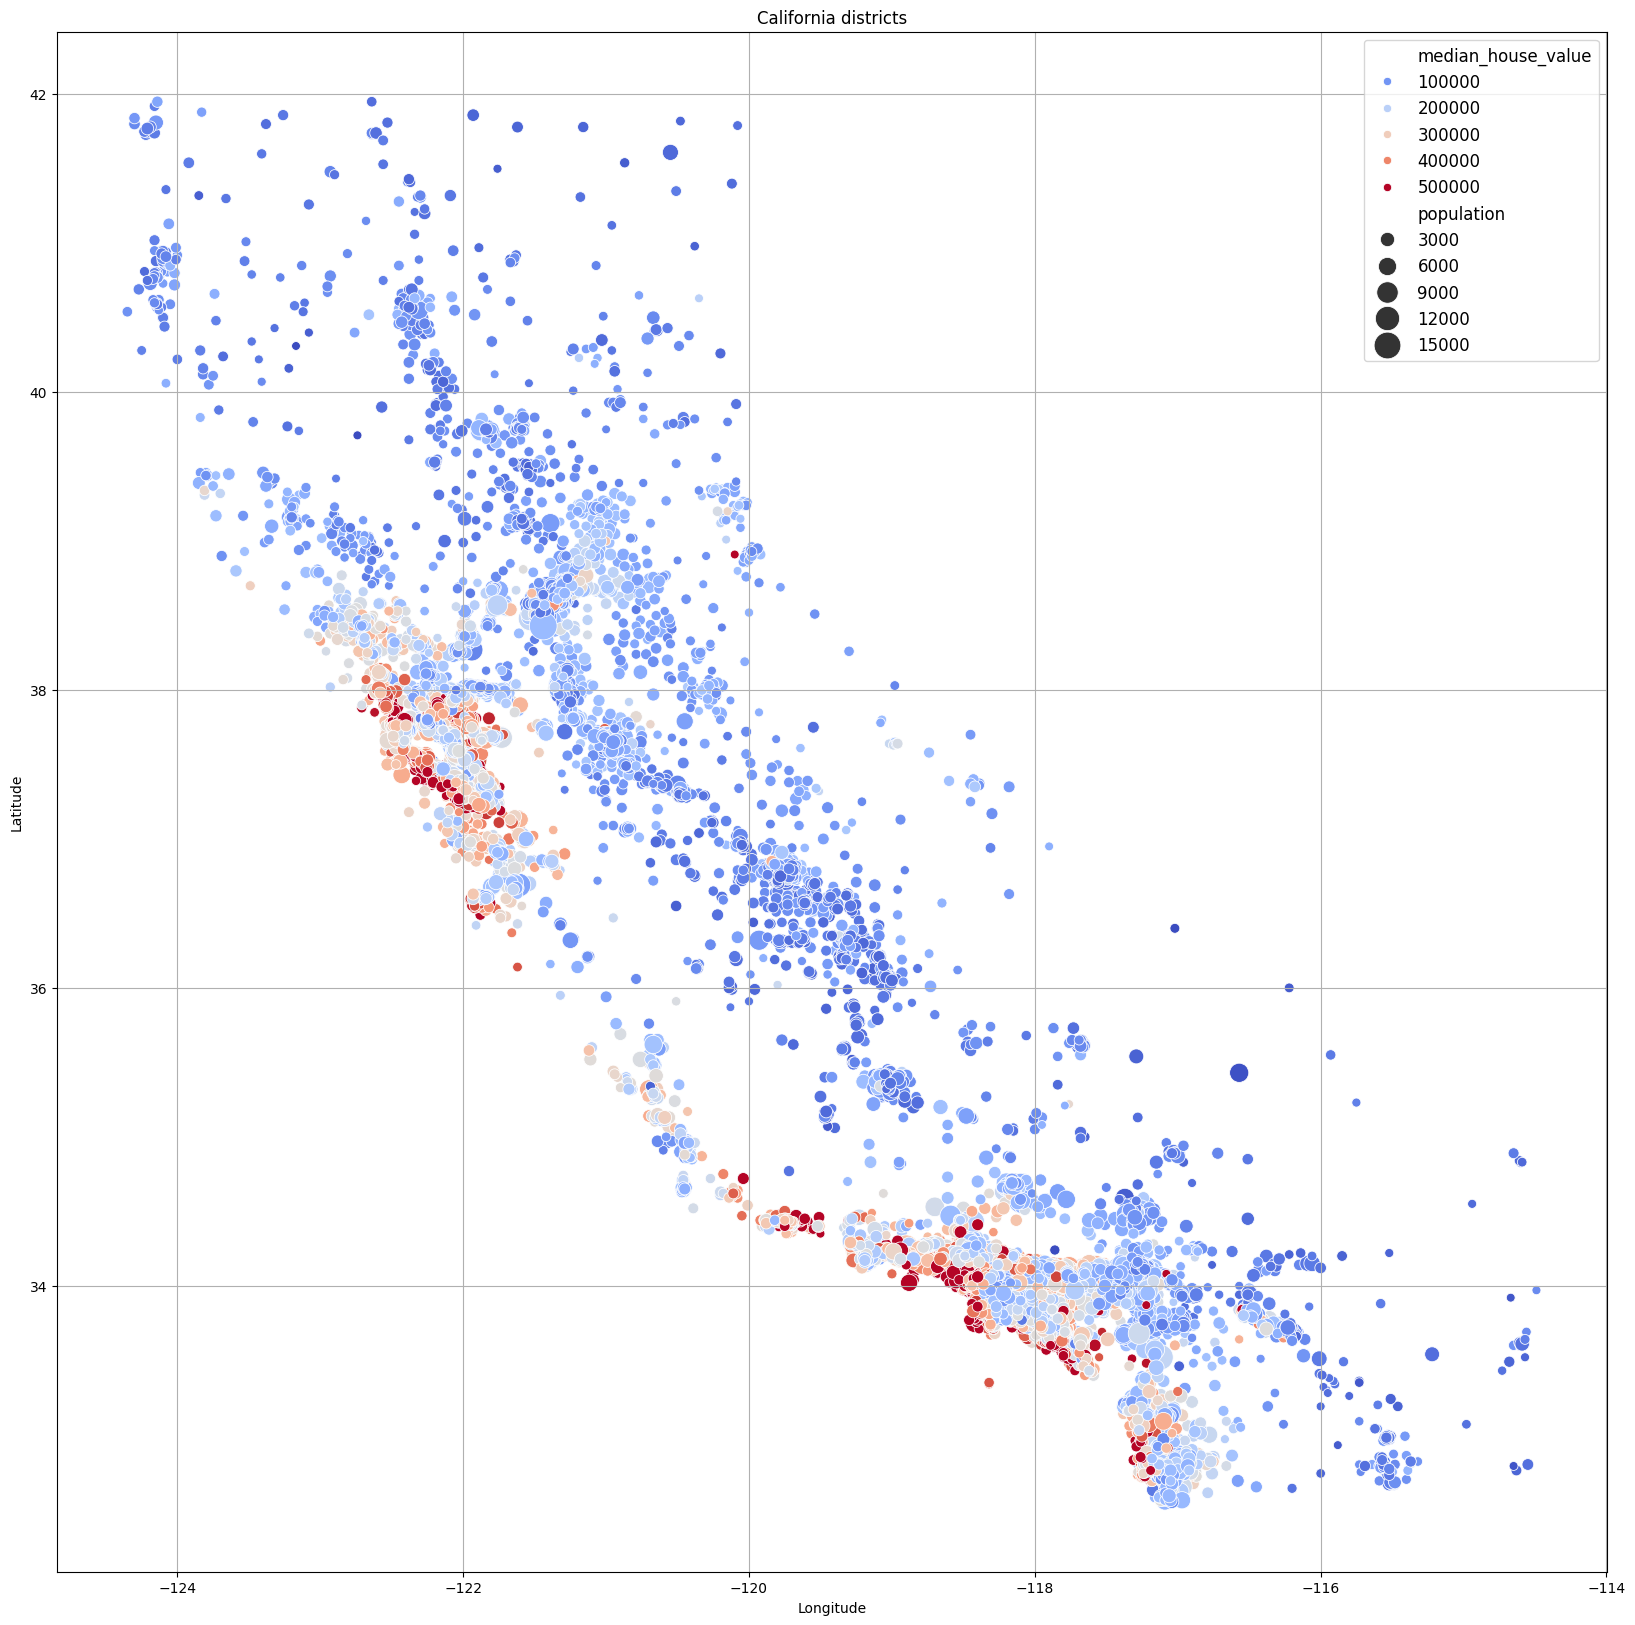

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(20, 20))

sns.scatterplot(
    data=housing,
    x='longitude',
    y='latitude',
    hue='median_house_value',
    size='population',
    sizes=(40, 400),
    palette='coolwarm',
    )

ax.set(xlabel='Longitude', ylabel='Latitude', title='California districts')
plt.legend(bbox_to_anchor=(1, 1),  fontsize=12)
plt.grid(True)

Using Pandas Plotting for plot different categories of the Data in Matrix form

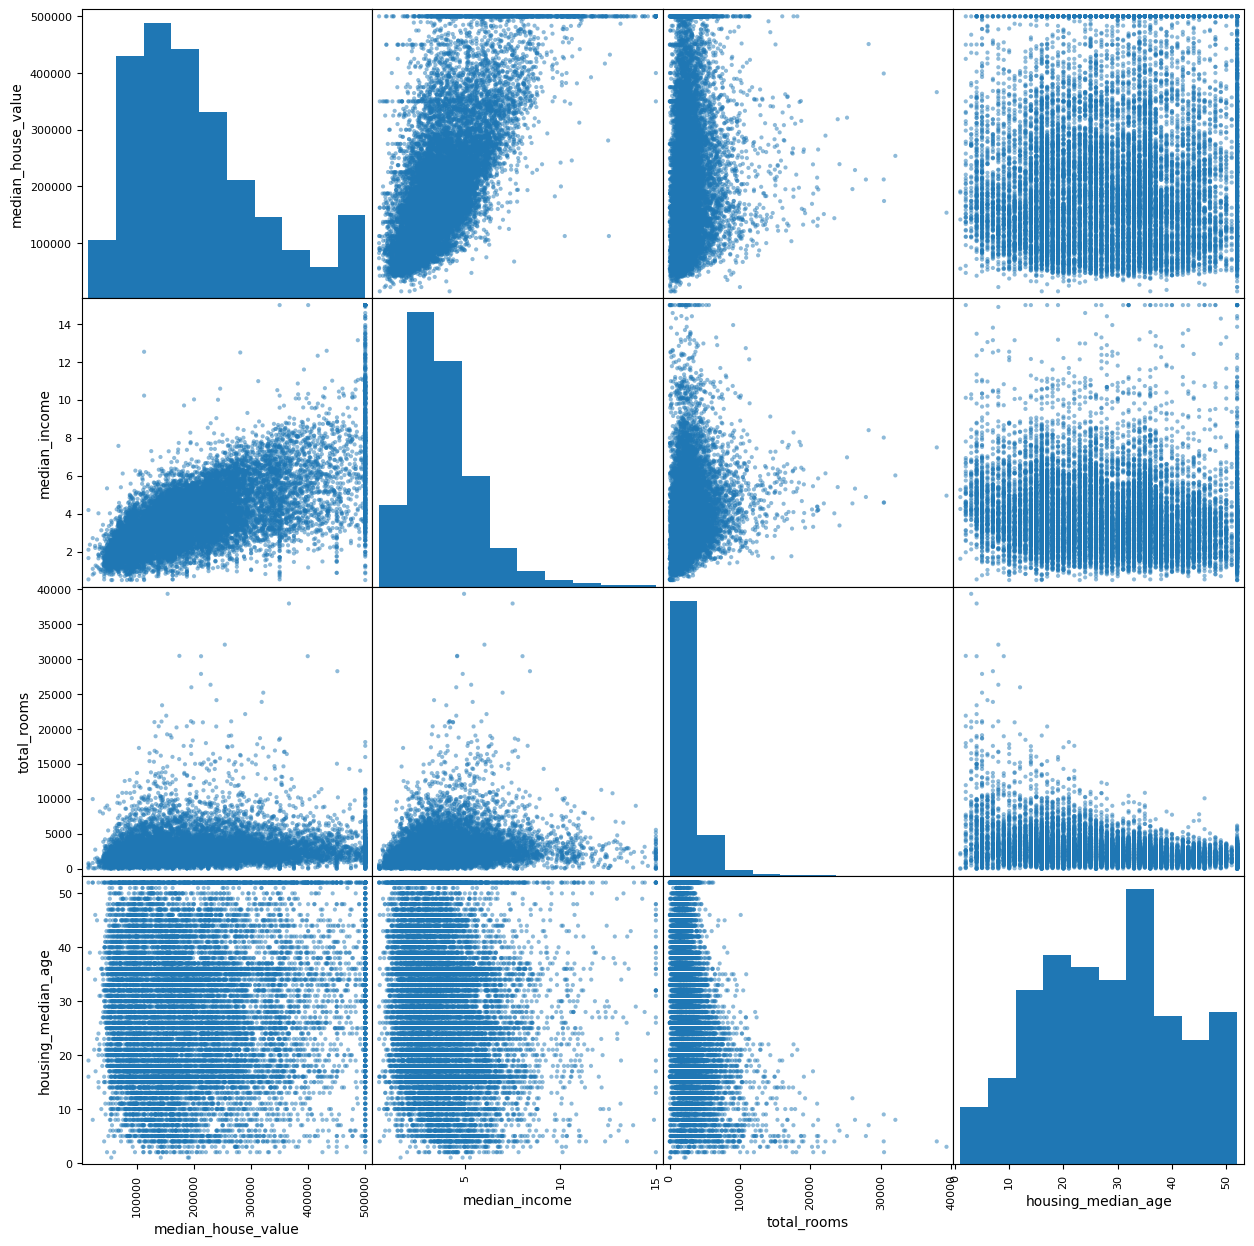

In [20]:
#using scatter_matrix 
from pandas.plotting import  scatter_matrix

attribute = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter = scatter_matrix(housing[attribute], figsize=(15, 15))
plt.style.use("ggplot")
plt.show()

Median Income and Median House Value

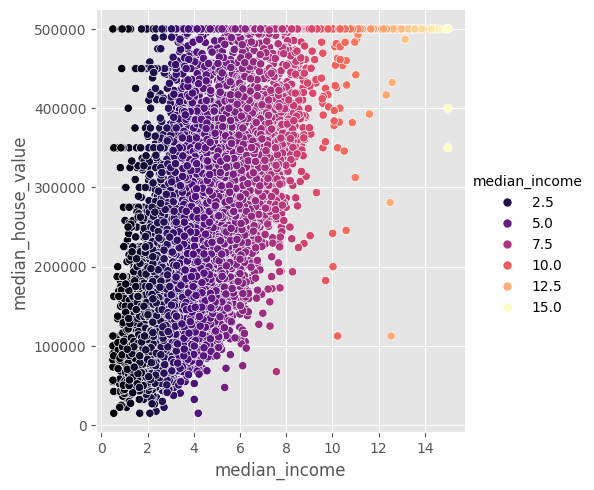

In [21]:
# import seaborn as sns

sns.relplot(
    data=housing,
    x="median_income",
    y="median_house_value",
    hue="median_income",
    palette="magma",
)

In [22]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,2
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,2
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,2
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3


In [23]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedroom_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_housing"] = housing["population"] / housing["households"]


Preparing Data for Machine Learning Algorithm

In [24]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_label = strat_train_set["median_house_value"].copy()

Clean the Data

In [25]:
# Data cleaning means droping the missing values from the dataset
# This can be done using: drop(), dropna(), fillna() Methods

# Using fillna() so that SimpleImputer can fill the null value

median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)


housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           16512 non-null  float64 
 1   latitude            16512 non-null  float64 
 2   housing_median_age  16512 non-null  float64 
 3   total_rooms         16512 non-null  float64 
 4   total_bedrooms      16512 non-null  float64 
 5   population          16512 non-null  float64 
 6   households          16512 non-null  float64 
 7   median_income       16512 non-null  float64 
 8   ocean_proximity     16512 non-null  object  
 9   income_cat          16512 non-null  category
dtypes: category(1), float64(8), object(1)
memory usage: 1.8+ MB


C:\Users\sunod\AppData\Local\Temp\ipykernel_2112\2795220461.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing['total_bedrooms'].fillna(median, inplace=True)


In [26]:
# Instead of using dropna() or fillna(), we will use SimpleImputer class of Scikit-Learn

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")


In [27]:
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [28]:
x = imputer.transform(housing_num)

In [29]:
housing_tr = pd.DataFrame(x, columns=housing_num.columns, index=housing_num.index)

In [30]:
housing_cat = housing[["ocean_proximity"]]

Using OrdinalEncoder from sklearn.preprocessing is encoding the object data into numerical data because the AI models are not able to understand the data in string or alphbetical form.

And using the OneHotEncoder ensure that it spare the numerical data that is encoded to numercial data sparses the data into matrix of 0s and 1 as:
[[0 0 0 1 0]
[0 1 0 0 0]]


In [31]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [32]:
cat_encode = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encode.fit_transform(housing_cat)

In [33]:
housing_cat_1hot

# To spare the housing_cat_1hot to matrix of 0s and 1s using toarray(). 
# It can be spared directing by passing the attribute of the OneHotEncoder as sparse_output=False

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [34]:
# housing_cat_1hot.toarray()

In [35]:
cat_encode.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [36]:
df_test = pd.DataFrame({
    "ocean_proximity": ["INLAND", "NEAR BAY"]
})

pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [37]:
cat_encode.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [38]:
df_test_unknown = pd.DataFrame({
    "ocean_proximity": ["<2H OCEAN", "ISLAND"]
})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [39]:
cat_encode.handle_unknown = "ignore"
cat_encode.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [40]:
cat_encode.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [41]:
cat_encode.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [42]:
# Scikit-Learn uses min max scaling to normalize the data. It is also called Normalization

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_scaled = scaler.fit_transform(housing_num)

In [43]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_scaled = std_scaler.fit_transform(housing_num)

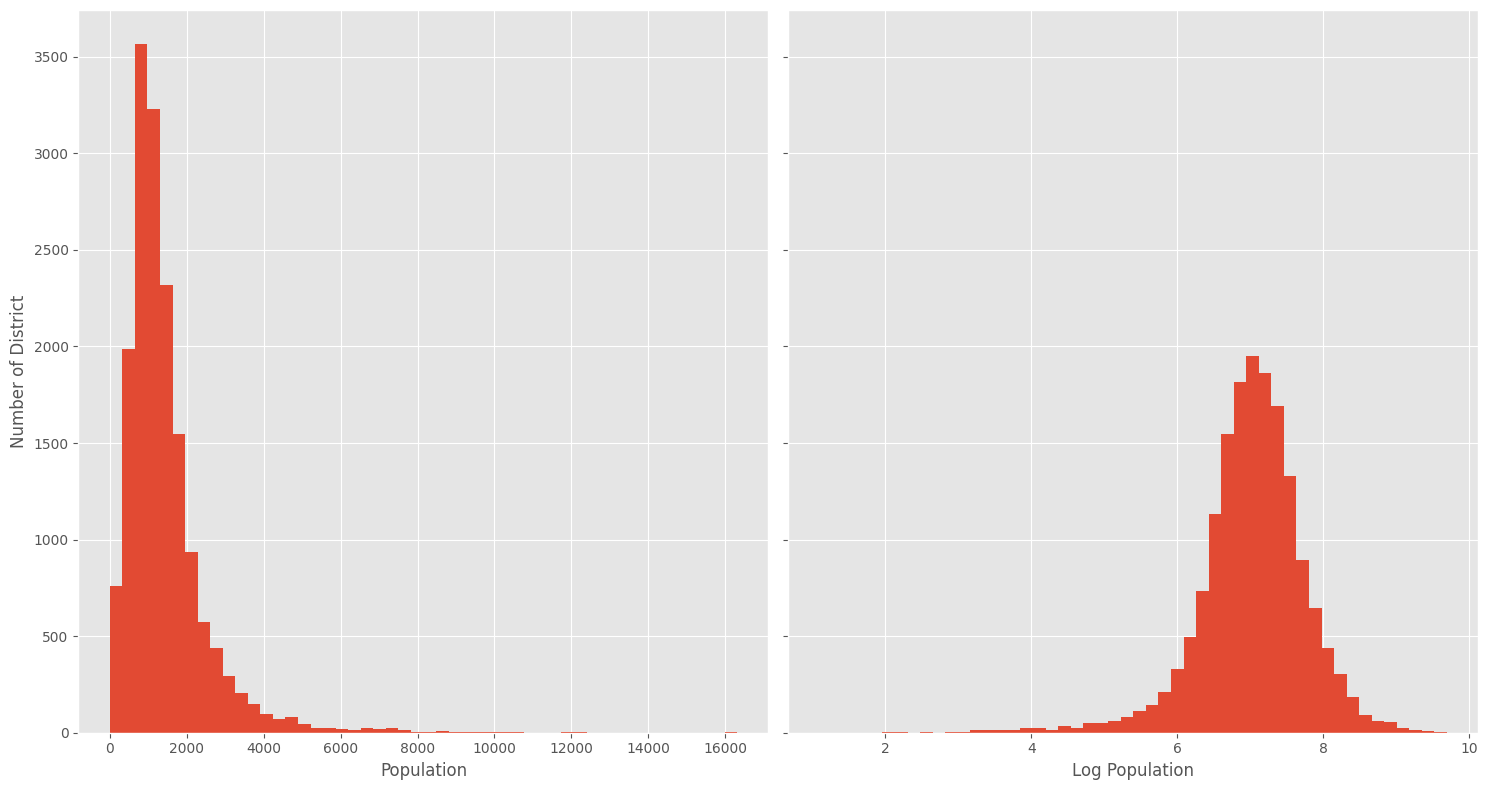

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 8), tight_layout=True, sharey=True)

housing["population"].hist(bins=50, ax=ax[0])
housing['population'].apply(np.log).hist(bins=50, ax=ax[1])

ax[0].set_xlabel("Population")
ax[1].set_xlabel("Log Population")
ax[0].set_ylabel("Number of District")
plt.show()

In [45]:
from sklearn.metrics.pairwise import rbf_kernel

age_similarity = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

age_similarity

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [46]:
## This is used for manually scaling the data and prone to error
# # StandardScaler expects 2D array and not 1D array
# from sklearn.linear_model import LinearRegression

# target_scaler = StandardScaler()
# scaled_labels = target_scaler.fit_transform(housing_label.to_frame())

# model = LinearRegression()
# model.fit(housing[["median_income"]], scaled_labels)
# some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

# scaled_predictions = model.predict(some_new_data)
# predictions = target_scaler.inverse_transform(scaled_predictions)

# predictions

In [47]:
# Automatically scaling the data using sklearn class and function which reduces error
# Instead using the manual scaling use TransformedTargetRegressor

from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

some_new_data = housing[["median_income"]].iloc[:5] 

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_label)

predictions = model.predict(some_new_data)
predictions


array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

Custom Transformers

In [48]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_prop = log_transformer.transform(housing[['population']])

In [49]:
rbf_tranformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_tranformer.transform(housing[["housing_median_age"]])

In [50]:
sf_coords = 37.7749, -122.41
sf_tranformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_tranformer.transform(housing[["latitude", "longitude"]])

In [51]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1. , 2.], [3. , 4.]]))

array([[0.5 ],
       [0.75]])

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted


class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even thought we don't use it
        X = check_array(
            X
        )  # Check for the X that whether X is array with finit float values
        self.mean_ = X.mean(axis=0)  # this is for calculating the mean for fit()
        self.scale_ = X.std(
            axis=0
        )  # this is for calculating the standard deviation for fit()
        self.n_features_in_ = X.shape[1]  # every stores this in fit()
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [53]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_cluster=10, gamma=1.0, random_state=42):
        self.n_cluster = n_cluster
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_cluster, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f'Cluster {i} similarity' for i in range(self.n_cluster)]

In [54]:
cluster_simil = ClusterSimilarity(n_cluster=10, gamma=1, random_state=42)
similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']], sample_weight=housing_label)

In [55]:
similarities[:3].round(2)

array([[0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.13, 0.55, 0.  , 0.56],
       [0.64, 0.  , 0.11, 0.04, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.01, 0.  , 0.49, 0.59, 0.  , 0.28]])

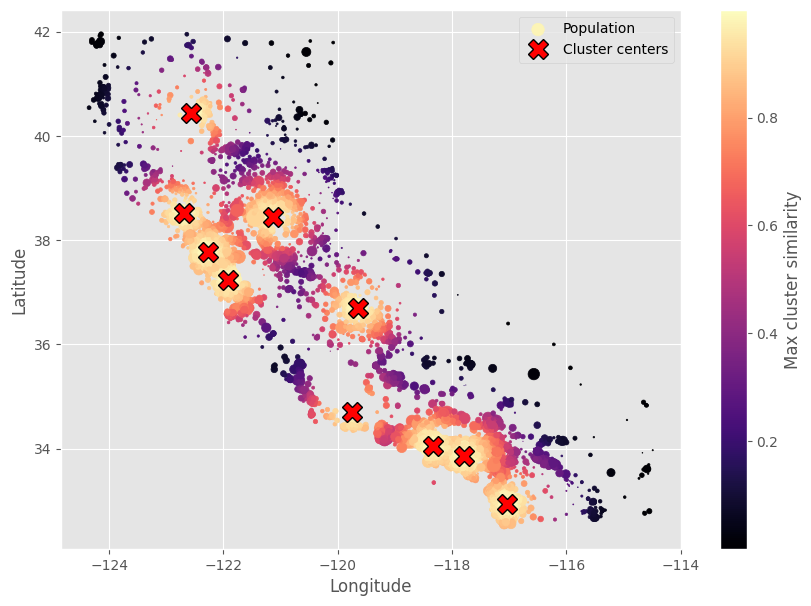

In [69]:
# Ploting the Cluster
housing_renamed = housing.rename(
    columns={
        "latitude": "Latitude",
        "longitude": "Longitude",
        "population": "Population",
        "median_house_value": "Median house value (usᴅ)",
    }
)
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(
    kind="scatter",
    x="Longitude",
    y="Latitude",
    grid=True,
    s=housing_renamed["Population"] / 100,
    label="Population",
    c="Max cluster similarity",
    cmap="magma",
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(10, 7),
)

plt.plot(
    cluster_simil.kmeans_.cluster_centers_[:, 1],
    cluster_simil.kmeans_.cluster_centers_[:, 0],
    linestyle="",
    color="red",
    markeredgecolor="black",
    marker="X",
    markersize=15,
    label="Cluster centers",
)
plt.legend(loc="upper right")
plt.show()

Transformation Pipelines

In [74]:
from sklearn.pipeline import Pipeline, make_pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardscaler", StandardScaler()),
])

In [ ]:
# Instead of making the pipeline with name of the Methods they can be called without naming them

# num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())


In [75]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [77]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared,
    columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index,
)

df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396
